In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
import sys
sys.path.append('../')  

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Environment configuration. SpatialGlue pacakge can be implemented with either CPU or GPU. GPU acceleration is highly recommend for imporoved efficiency.
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

# the location of R, which is required for the 'mclust' algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/usr/lib/R'


In [3]:
# read data
file_fold = '/data/SpaOmicsVAE-main/data/Mouse_Spleen/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

/root/anaconda3/envs/deepst_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
# Specify data type
data_type = 'SPOTS'

# Fix random seed
from SpaOmicsVAE.preprocess import fix_seed
random_seed = 2022
fix_seed(random_seed)

In [ ]:
from SpaOmicsVAE.SpaOmicsVAE import get_augment
from scipy.sparse import csr_matrix

adata_omics1=get_augment(adata=adata_omics1, spatial_type="BallTree",random_seed=2024)
adata_omics2=get_augment(adata=adata_omics2, spatial_type="BallTree",random_seed=2024)

augment_sparse1 = csr_matrix(adata_omics1.obsm['augment_gene_data'])
augment_sparse2 = csr_matrix(adata_omics2.obsm['augment_gene_data'])

adata_omics1.X = augment_sparse1+adata_omics1.X
adata_omics2.X = augment_sparse2+adata_omics2.X



Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0
Gene correlation calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_all'] !


Find adjacent spots of each spot: 100%|██████████ [ time left: 00:00 ]


Data augmentation completed!
Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0
Gene correlation calculting Done!


Find adjacent spots of each spot:  38%|███▊       [ time left: 00:00 ]

The weight result of image feature is added to adata.obsm['weights_matrix_all'] !


Find adjacent spots of each spot: 100%|██████████ [ time left: 00:00 ]


Data augmentation completed!


In [6]:
from SpaOmicsVAE.preprocess import clr_normalize_each_cell, pca


# RNA
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=adata_omics2.n_vars-1)

# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
sc.pp.scale(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=adata_omics2.n_vars-1)

/root/anaconda3/envs/deepst_env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [7]:
from SpaOmicsVAE.preprocess import construct_neighbor_graph
data = construct_neighbor_graph(adata_omics1, adata_omics2, datatype=data_type)

In [8]:
# define model
from SpaOmicsVAE.SpaOmicsVAE import Train_SpaOmicsVAE
model = Train_SpaOmicsVAE(data, datatype=data_type, device=device)

# train model
output = model.train()

  0%|          | 0/800 [00:00<?, ?it/s]/root/anaconda3/envs/deepst_env/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/data/SpaOmicsVAE-main/tutorial/../SpaOmicsVAE/model.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|██████████| 800/800 [00:25<00:00, 31.19it/s]

Model training completed!



In [9]:
adata = adata_omics1.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1'].copy()
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2'].copy()
adata.obsm['SpaOmicsVAE'] = output['SpaOmicsVAE'].copy()


In [11]:
# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpaOmicsVAE.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata, key='SpaOmicsVAE', add_key='SpaOmicsVAE', n_clusters=5, method=tool, use_pca=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


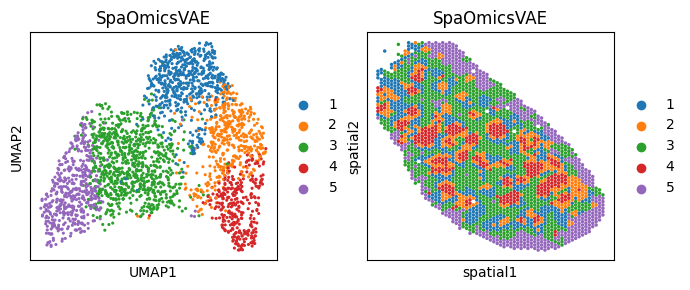

In [12]:
# visualization
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(7, 3))
sc.pp.neighbors(adata, use_rep='SpaOmicsVAE', n_neighbors=10)
sc.tl.umap(adata)

sc.pl.umap(adata, color='SpaOmicsVAE', ax=ax_list[0], title='SpaOmicsVAE', s=20, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpaOmicsVAE', ax=ax_list[1], title='SpaOmicsVAE', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()